In [1]:
# !pip install seaborn

In [2]:
# !pip install tabulate

Libraries imported successfully

Performance Comparison:
   Engine               Query  Duration (seconds)  Row Count
0  DuckDB  simple_aggregation            4.422371   77966324
1  DuckDB    complex_analysis            6.988170   35255440
2  DuckDB   advanced_analysis           13.014679   77301055
3   Spark  simple_aggregation            7.731309   77966324
4   Spark    complex_analysis            9.759496   35255440
5   Spark   advanced_analysis           16.224427   77301055


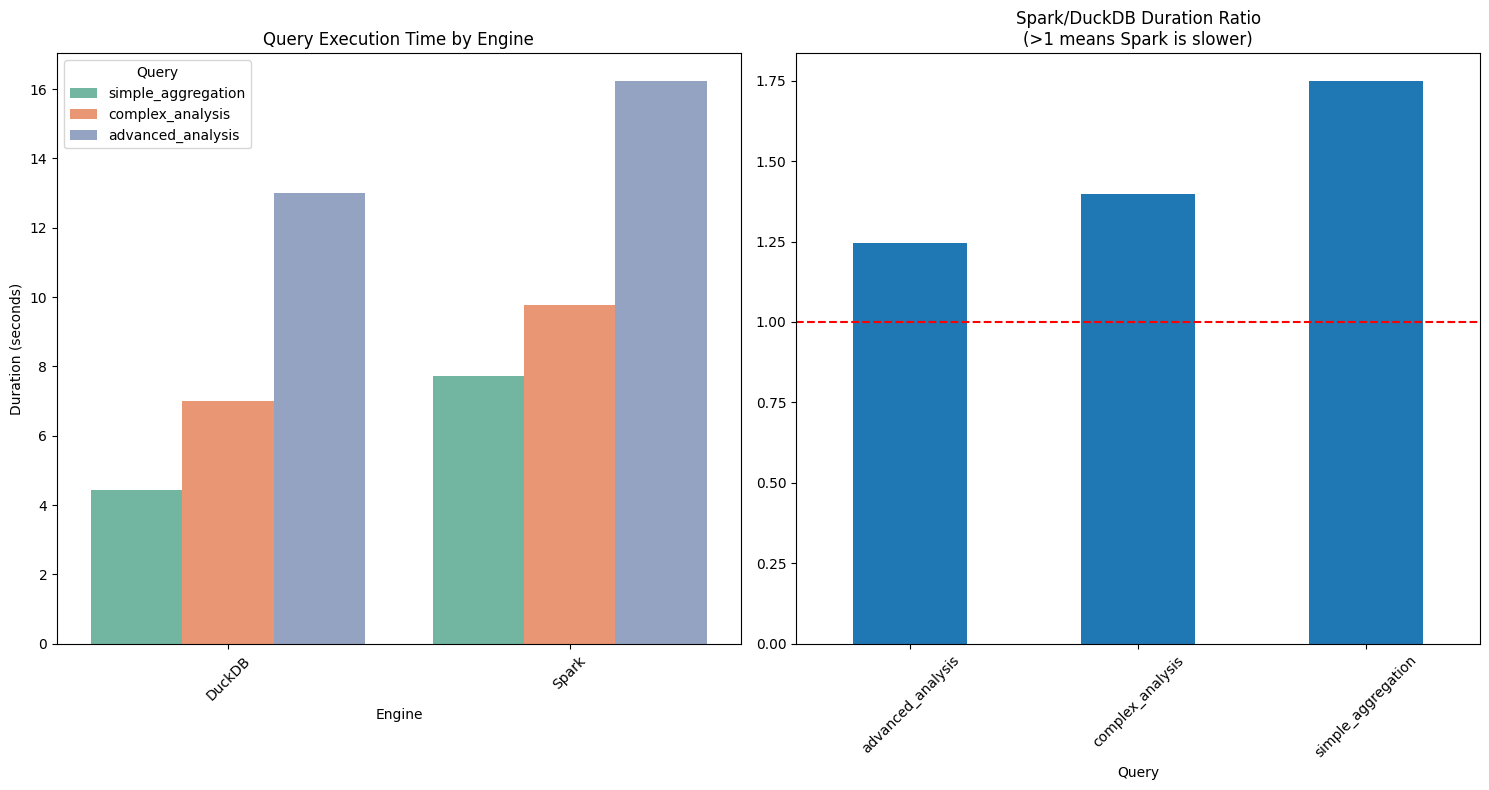

In [3]:
# Cell 1: Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import numpy as np

print("Libraries imported successfully")

# Cell 2: Load benchmark results
def load_benchmark_results(filenames):
    """Load benchmark results from JSON files"""
    results = {}
    for engine, filename in filenames.items():
        with open(filename, 'r') as f:
            results[engine] = json.load(f)
    return results

# Load results
benchmark_files = {
    'DuckDB': 'duckdb_benchmark_results.json',
    'Spark': 'spark_benchmark_results.json'
}

results = load_benchmark_results(benchmark_files)

# Cell 3: Create comparison dataframe
def create_comparison_df(results):
    """Create a DataFrame for performance comparison"""
    data = []
    for engine, result in results.items():
        for query_name, query_data in result['queries'].items():
            data.append({
                'Engine': engine,
                'Query': query_name,
                'Duration (seconds)': query_data['duration'],
                'Row Count': query_data.get('row_count', 0)
            })
    return pd.DataFrame(data)

comparison_df = create_comparison_df(results)
print("\nPerformance Comparison:")
print(comparison_df.to_string())

# Cell 4: Visualize performance comparison
def plot_performance_comparison(comparison_df):
    """Create performance comparison visualizations"""
    plt.figure(figsize=(15, 8))
    
    # Query duration comparison
    plt.subplot(1, 2, 1)
    sns.barplot(data=comparison_df, x='Engine', y='Duration (seconds)', 
                hue='Query', palette='Set2')
    plt.title('Query Execution Time by Engine')
    plt.xticks(rotation=45)
    
    # Duration ratio analysis
    plt.subplot(1, 2, 2)
    pivot_df = comparison_df.pivot(index='Query', columns='Engine', 
                                 values='Duration (seconds)')
    ratio = pivot_df['Spark'] / pivot_df['DuckDB']
    ratio.plot(kind='bar')
    plt.title('Spark/DuckDB Duration Ratio\n(>1 means Spark is slower)')
    plt.axhline(y=1, color='r', linestyle='--')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('performance_comparison.png')
    plt.show()

plot_performance_comparison(comparison_df)


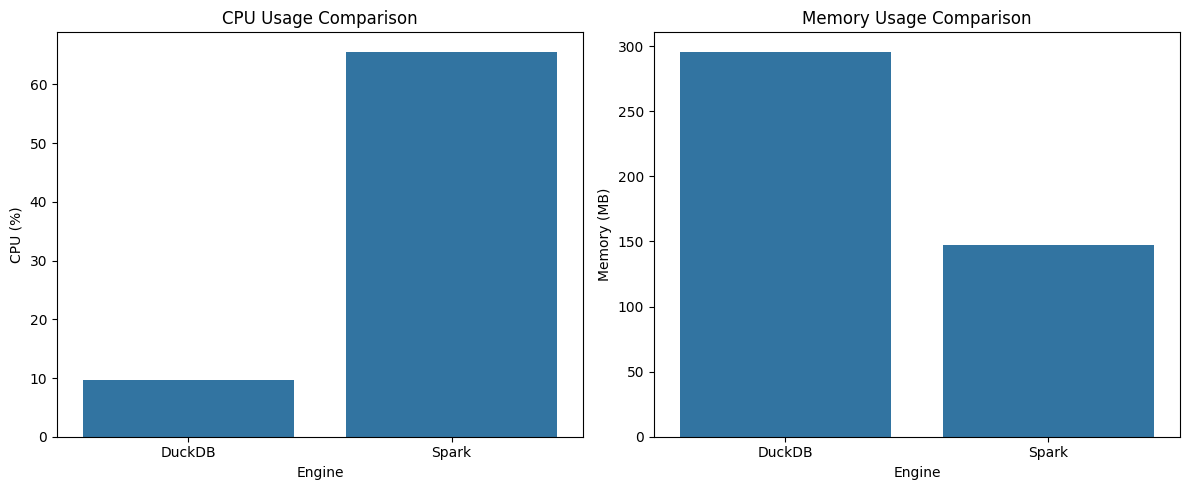

In [4]:

# Cell 5: Resource usage comparison
def plot_resource_usage(results):
    """Plot resource usage comparison"""
    resource_data = []
    for engine, result in results.items():
        if 'resources' in result:
            resource_data.append({
                'Engine': engine,
                'CPU (%)': result['resources']['cpu_percent'],
                'Memory (MB)': result['resources'].get('memory_mb', 0)
            })
    
    if resource_data:
        resource_df = pd.DataFrame(resource_data)
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.barplot(data=resource_df, x='Engine', y='CPU (%)')
        plt.title('CPU Usage Comparison')
        
        plt.subplot(1, 2, 2)
        sns.barplot(data=resource_df, x='Engine', y='Memory (MB)')
        plt.title('Memory Usage Comparison')
        
        plt.tight_layout()
        plt.savefig('resource_comparison.png')
        plt.show()

plot_resource_usage(results)


In [5]:
def generate_report(comparison_df, results):
    """Generate a comprehensive markdown report from benchmark results.
    
    Args:
        comparison_df (pd.DataFrame): DataFrame with query performance comparisons
        results (dict): Dictionary containing detailed benchmark results
        
    Returns:
        str: Markdown formatted report
    """
    report = f"""# NYC Taxi Data Analysis Benchmark Report
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Environment Setup

### Docker Infrastructure
- **Required Components**:
  * Apache Spark with Iceberg support
  * REST catalog service
  * MinIO object storage
  * MinIO client for bucket setup

### Initial Setup
1. **Clone Repository and Create Directories**:
   ```bash
   git clone <repository-url>
   ```

2. **Docker Compose Environment**:
   ```yaml
   # Key services from docker-compose.yml:
   - spark-iceberg (Jupyter + Spark): ports 8888, 8080
   - rest (Iceberg REST catalog): port 8181
   - minio (Object storage): ports 9000, 9001
   - mc (MinIO client): for bucket setup
   ```

3. **Start the Environment**:
   ```bash
   docker-compose up -d
   ```

4. **Access Points**:
   - Jupyter Lab: http://localhost:8888
   - MinIO Console: http://localhost:9001
   - Iceberg REST: http://localhost:8181

## Step-by-Step Instructions

1. **Data Download and Preparation (00_download_data.ipynb)**
   - Run this notebook first to download NYC Taxi data for 2022 and 2023
   - The notebook will:
     * Create a data directory
     * Download Parquet files for each month
     * Verify downloaded files
     * Display data preview and statistics
   - Expected runtime: ~30 minutes depending on network speed
   - Total data size: ~1.2GB (2 years of data)

2. **Data Ingestion to Iceberg (01_data_ingestion.ipynb)**
   - Loads the downloaded Parquet files into Apache Iceberg
   - Creates a properly partitioned table structure
   - Includes data validation steps
   - Key configurations:
     ```python
     DATABASE_NAME = "nyc"
     TABLE_NAME = "taxis"
     PARTITION_BY = "days(tpep_pickup_datetime)"
     ```
   - Expected runtime: ~45 minutes
   - Key operations:
     * Iceberg table creation with optimized settings
     * Batch loading of monthly files
     * Partition by pickup date for query optimization

3. **DuckDB Analysis (02_duckdb_analysis.ipynb)**
   - Performs benchmark queries using DuckDB
   - Connects to Iceberg tables
   - Executes simple and complex analysis
   - Records performance metrics
   - Expected runtime: ~10 minutes

4. **Spark Analysis (03_spark_analysis.ipynb)**
   - Similar analysis using Apache Spark
   - Provides comparison point for DuckDB
   - Uses same queries for fair comparison
   - Expected runtime: ~15 minutes

5. **Benchmark Comparison (04_benchmark_comparison.ipynb)**
   - Generates visualizations and comparisons
   - Creates this comprehensive report
   - Analyzes performance differences
   - Expected runtime: ~5 minutes

## Container Architecture
```
┌─────────────────┐    ┌──────────────┐
│  Spark-Iceberg  │◄───┤ Iceberg REST │
│  (Processing)   │    │   Catalog    │
└────────┬────────┘    └──────┬───────┘
         │                    │
         │                    │
         ▼                    ▼
┌─────────────────┐    ┌──────────────┐
│     MinIO       │◄───┤  MinIO Client │
│ (Object Store)  │    │ (Setup/Admin) │
└─────────────────┘    └──────────────┘
```

## Dataset Context
- **Dataset**: NYC Yellow Taxi Trip Records 2022-2023
- **Size**: ~80 million records (~1.2GB Compressed)
- **Source**: NYC Taxi & Limousine Commission (TLC)
- **Storage Format**: Apache Iceberg (Parquet files)
- **Partitioning**: By days(tpep_pickup_datetime)
- **Data Fields**: 19 columns including timestamps, locations, payment info, and trip metrics

## Query Definitions

### Simple Aggregation Query
```sql
SELECT
    COUNT(*) AS total_records,
    AVG(trip_distance) AS avg_trip_distance,
    MAX(total_amount) AS max_total_amount,
    MIN(fare_amount) AS min_fare_amount
FROM nyc_taxis
```
**Purpose**: Basic statistics about taxi trips including total count, average distance, and fare extremes.

**Complexity Factors**:
- Full table scan required
- Multiple aggregation functions
- Numeric computations

### Complex Analysis Query
```sql
SELECT
    payment_type,
    COUNT(*) AS trip_count,
    AVG(total_amount) AS avg_total_amount,
    MAX(tip_amount) AS max_tip_amount,
    SUM(CASE WHEN passenger_count > 1 THEN 1 ELSE 0 END) as shared_rides
FROM nyc_taxis
WHERE trip_distance > 2 AND total_amount > 0
GROUP BY payment_type
ORDER BY trip_count DESC
```
**Purpose**: Advanced analysis of payment patterns with multiple derived metrics

**Complexity Factors**:
- Filtering conditions
- Grouped aggregations
- Conditional counting
- Sorting of results

### Advanced Analysis Query
```sql
SELECT 
    DATE_TRUNC('month', tpep_pickup_datetime) AS month,
    payment_type,
    ROUND(AVG(fare_amount), 2) AS avg_base_fare,
    ROUND(AVG(total_amount), 2) AS avg_total_fare,
    ROUND(AVG(total_amount - fare_amount), 2) AS interpolated_tip,
    COUNT(*) AS num_rides,
    ROUND(STDDEV(total_amount), 2) AS fare_stddev,
    ROUND(AVG(total_amount) - LAG(AVG(total_amount)) OVER (PARTITION BY payment_type ORDER BY DATE_TRUNC('month', tpep_pickup_datetime)), 2) AS fare_change,
    ROUND(100 * (AVG(total_amount) - LAG(AVG(total_amount)) OVER (PARTITION BY payment_type ORDER BY DATE_TRUNC('month', tpep_pickup_datetime))) / LAG(AVG(total_amount)) OVER (PARTITION BY payment_type ORDER BY DATE_TRUNC('month', tpep_pickup_datetime)), 2) AS fare_change_pct,
    CASE
        WHEN 100 * (AVG(total_amount) - LAG(AVG(total_amount)) OVER (PARTITION BY payment_type ORDER BY DATE_TRUNC('month', tpep_pickup_datetime))) / LAG(AVG(total_amount)) OVER (PARTITION BY payment_type ORDER BY DATE_TRUNC('month', tpep_pickup_datetime)) < -20 THEN 'Strong Decrease'
        WHEN 100 * (AVG(total_amount) - LAG(AVG(total_amount)) OVER (PARTITION BY payment_type ORDER BY DATE_TRUNC('month', tpep_pickup_datetime))) / LAG(AVG(total_amount)) OVER (PARTITION BY payment_type ORDER BY DATE_TRUNC('month', tpep_pickup_datetime)) < -5 THEN 'Decrease'
        WHEN 100 * (AVG(total_amount) - LAG(AVG(total_amount)) OVER (PARTITION BY payment_type ORDER BY DATE_TRUNC('month', tpep_pickup_datetime))) / LAG(AVG(total_amount)) OVER (PARTITION BY payment_type ORDER BY DATE_TRUNC('month', tpep_pickup_datetime)) < 5 THEN 'No Change'
        WHEN 100 * (AVG(total_amount) - LAG(AVG(total_amount)) OVER (PARTITION BY payment_type ORDER BY DATE_TRUNC('month', tpep_pickup_datetime))) / LAG(AVG(total_amount)) OVER (PARTITION BY payment_type ORDER BY DATE_TRUNC('month', tpep_pickup_datetime)) < 20 THEN 'Increase' 
        ELSE 'Strong Increase'
    END AS trend_category
FROM nyc_taxis
GROUP BY payment_type, DATE_TRUNC('month', tpep_pickup_datetime)
```
**Purpose**: Trend analysis over monthly periods with categorization of percent changes

**Complexity Factors**:
- Date truncation and grouping
- Windowed functions for previous month comparisons
- Multiple levels of aggregation
- Complex CASE statement for trend labeling
- Many derived metrics

## Performance Results

### Query Execution Times
{comparison_df.to_markdown()}

### Resource Usage
| Engine | Peak CPU % | Memory (MB) |
|--------|------------|-------------|
| DuckDB | {results['DuckDB']['resources']['cpu_percent']:.1f} | {results['DuckDB']['resources']['memory_mb']:.0f} |
| Spark  | {results['Spark']['resources']['cpu_percent']:.1f} | {results['Spark']['resources']['memory_mb']:.0f} |

## Performance Analysis

### Query Performance
- Fastest simple query: {comparison_df[comparison_df['Query']=='simple_aggregation']['Duration (seconds)'].min():.2f}s ({comparison_df[comparison_df['Query']=='simple_aggregation']['Duration (seconds)'].idxmin()})
- Fastest complex query: {comparison_df[comparison_df['Query']=='complex_analysis']['Duration (seconds)'].min():.2f}s ({comparison_df[comparison_df['Query']=='complex_analysis']['Duration (seconds)'].idxmin()})
- Fastest advanced query: {comparison_df[comparison_df['Query']=='advanced_analysis']['Duration (seconds)'].min():.2f}s ({comparison_df[comparison_df['Query']=='advanced_analysis']['Duration (seconds)'].idxmin()})
- DuckDB average time: {comparison_df[comparison_df['Engine']=='DuckDB']['Duration (seconds)'].mean():.2f}s
- Spark average time: {comparison_df[comparison_df['Engine']=='Spark']['Duration (seconds)'].mean():.2f}s
- Speed ratio (Spark/DuckDB): {(comparison_df[comparison_df['Engine']=='Spark']['Duration (seconds)'].mean() / comparison_df[comparison_df['Engine']=='DuckDB']['Duration (seconds)'].mean()):.2f}x

## Engine Characteristics

### DuckDB ({results['DuckDB']['version']})
- Excellent performance on grouped aggregations
- Lower resource consumption ({results['DuckDB']['resources']['memory_mb']:.0f}MB peak memory)
- Simpler deployment and configuration
- Single-node execution optimized

### Spark ({results['Spark']['version']})
- Better full table scan performance
- Higher resource utilization ({results['Spark']['resources']['memory_mb']:.0f}MB peak memory)
- Distributed processing capability
- Complex operation handling

## Optimization Findings

### Data Organization
1. Partitioning Strategy:
   - Daily partitioning effective for both engines
   - Metadata overhead well-managed
   - Version hints improve query planning

2. Query Optimization:
   - Both engines push filters to storage
   - Partition pruning effective
   - Memory-efficient grouping in DuckDB
   - Spark shows overhead in shuffle operations

## Recommendations

1. Engine Selection:
   - Use DuckDB for ad-hoc analysis and complex grouping
   - Use Spark for large-scale processing and distributed workloads
   - Consider resource constraints and scaling needs

2. Performance Optimization:
   - Maintain optimal partition size
   - Use version hints
   - Monitor resource usage
   - Consider materialized views for common queries

## Visual Comparisons
### Performance Comparison
![Performance Comparison](performance_comparison.png)

### Resource Usage
![Resource Usage Comparison](resource_comparison.png)

## Resources
- Complete benchmark code available in repository
- Raw performance data in JSON files
- Configuration files in docker-compose.yml
- Visualization outputs in PNG format"""
    
    # Save report to file
    with open('benchmark_report.md', 'w') as f:
        f.write(report)
    print("Report saved to 'benchmark_report.md'")
    
    return report

report = generate_report(comparison_df, results)
print("\nReport generated and saved to 'benchmark_report.md'")

Report saved to 'benchmark_report.md'

Report generated and saved to 'benchmark_report.md'
